In [1]:
import torch
from transformers import  Qwen2_5_VLForConditionalGeneration, AutoProcessor
import math
import json
import matplotlib.pyplot as plt
import vision_process
import re
import os
from collections import defaultdict
from pprint import pprint
from PIL import Image
from typing import List


from vision_process import process_vision_info


from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch


/home/s48gb/Desktop/GenAI4E/aicity_02/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

# processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

# model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
# model.to("cuda:0")



Loading checkpoint shards: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [3]:
train_json = json.load(
    open("/home/s48gb/Desktop/GenAI4E/aicity_02/preprocessed_dataset/train_data/train.json")
)

In [4]:
sample = list(
    filter(lambda x: "20230707_17_CY23_T1" in x['image'], train_json)
)

In [5]:
view2info = defaultdict(list)

phases = ['phase0', 'phase1', 'phase2', 'phase3', 'phase4']

for s in sample:
    image_path = s['image']
    phases_math = re.search(
        r'_phase(\d+)', image_path
    )
    phase_number = f"phase{phases_math.group(1)}"
    view2info[phase_number].append(
        {
            'image_path': image_path,
            'conversations': s['conversations']
        }
    )


In [6]:
# environment

sample_phase0 = view2info['phase0']

vehicle_view_path = list(
    filter(lambda x: 'vehicle' in x['image_path'], sample_phase0) 
)[0]

overview_path = list(
    filter(lambda x: 'vehicle' not in x['image_path'], sample_phase0)
)[0]



vehicle_image = Image.open(vehicle_view_path['image_path'])

overview_image = Image.open(overview_path['image_path'])



In [7]:
caption = sample_phase0[0]['conversations'][1]['value']

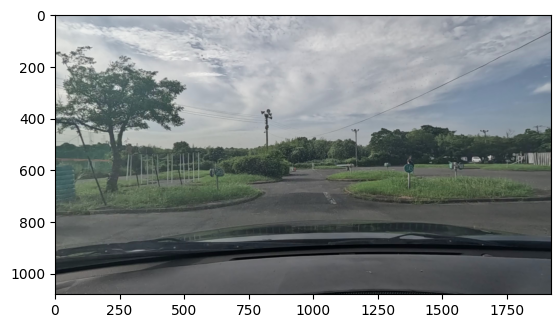

In [8]:
plt.imshow(vehicle_image)

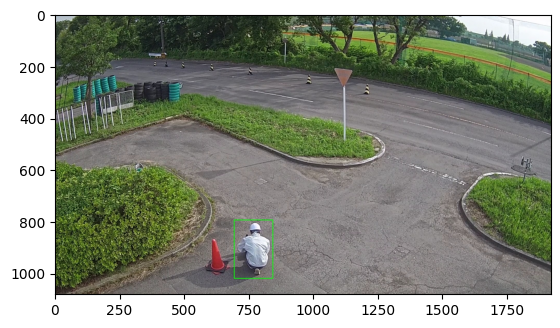

In [9]:
plt.imshow(overview_image)

In [10]:
prompt = """
You are an expert in environment traffic analysis. Given the images, your task is to generate a comprehensive caption. This caption should include several components, including:

1. Road surfaces, what is the road made of?
2. traffic volume condition
3. other conditions that related to enviroment traffic conditions

Also, make the caption short and succint.
"""

In [11]:
def inference(
    list_of_images: List[str],
    prompt: str
):
    messages = [
        {
            'role': 'user',
            'content': [
                {'type': 'image', 'image': f"file://{img_path}"} for img_path in list_of_images
            ] + [
                {"type": "text", "text": prompt}
            ]
        }
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    pprint(f"{messages=}")

    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

In [12]:
chat_answers = inference(
    [overview_path['image_path']],
    prompt
)

("messages=[{'role': 'user', 'content': [{'type': 'image', 'image': "
 "'file:///home/s48gb/Desktop/GenAI4E/aicity_02/preprocessed_dataset/bbox_extracted/train/20230707_17_CY23_T1/20230707_17_CY23_T1_Camera3_3_phase0_bbox.jpg'}, "
 "{'type': 'text', 'text': '\\nYou are an expert in environment traffic "
 'analysis. Given the images, your task is to generate a comprehensive '
 'caption. This caption should include several components, including:\\n\\n1. '
 'Road surfaces, what is the road made of?\\n2. traffic volume condition\\n3. '
 'other conditions that related to enviroment traffic conditions\\n\\nAlso, '
 "make the caption short and succint.\\n'}]}]")
image='file:///home/s48gb/Desktop/GenAI4E/aicity_02/preprocessed_dataset/bbox_extracted/train/20230707_17_CY23_T1/20230707_17_CY23_T1_Camera3_3_phase0_bbox.jpg'


In [13]:
chat_answers[0]

'The road surface appears to be asphalt, with visible cracks indicating wear. The traffic volume is low, with only one person visible on the road. The environment includes greenery, a grassy area, and a fenced sports field in the background, suggesting a recreational or training facility. Traffic cones and barriers are present, likely for safety or training purposes.'

In [ ]:
chat_ans = 'The road surface appears to be asphalt, with visible cracks indicating wear. The traffic volume is low, with only one person visible on the road. The environment includes greenery, a grassy area, and a fenced sports field in the background, suggesting a recreational or training facility. Traffic cones and barriers are present, likely for safety or training purposes.'


In [15]:
caption = """
"As for the environmental conditions, The weather is clear with bright brightness. The road surface is dry and level, made of asphalt. The traffic volume is light on this two-way residential road. There are no sidewalks on both sides, and no roadside strips. However, there are street lights illuminating the surroundings. An obstacle is present behind the pedestrian, approximately 1 meter in height and 0.5 meters in width."
"""